<a href="https://colab.research.google.com/github/Karthik-Pydishetty/skin-cancer-detection-nir/blob/main/NIr_Specttrc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install optuna

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.3 MB/s eta 0:00:00


This project analyzes near-infrared (NIR) spectroscopy data from skin lesions to differentiate between benign and malignant samples and find wavelength intervals that are most useful for predicting cancer cells

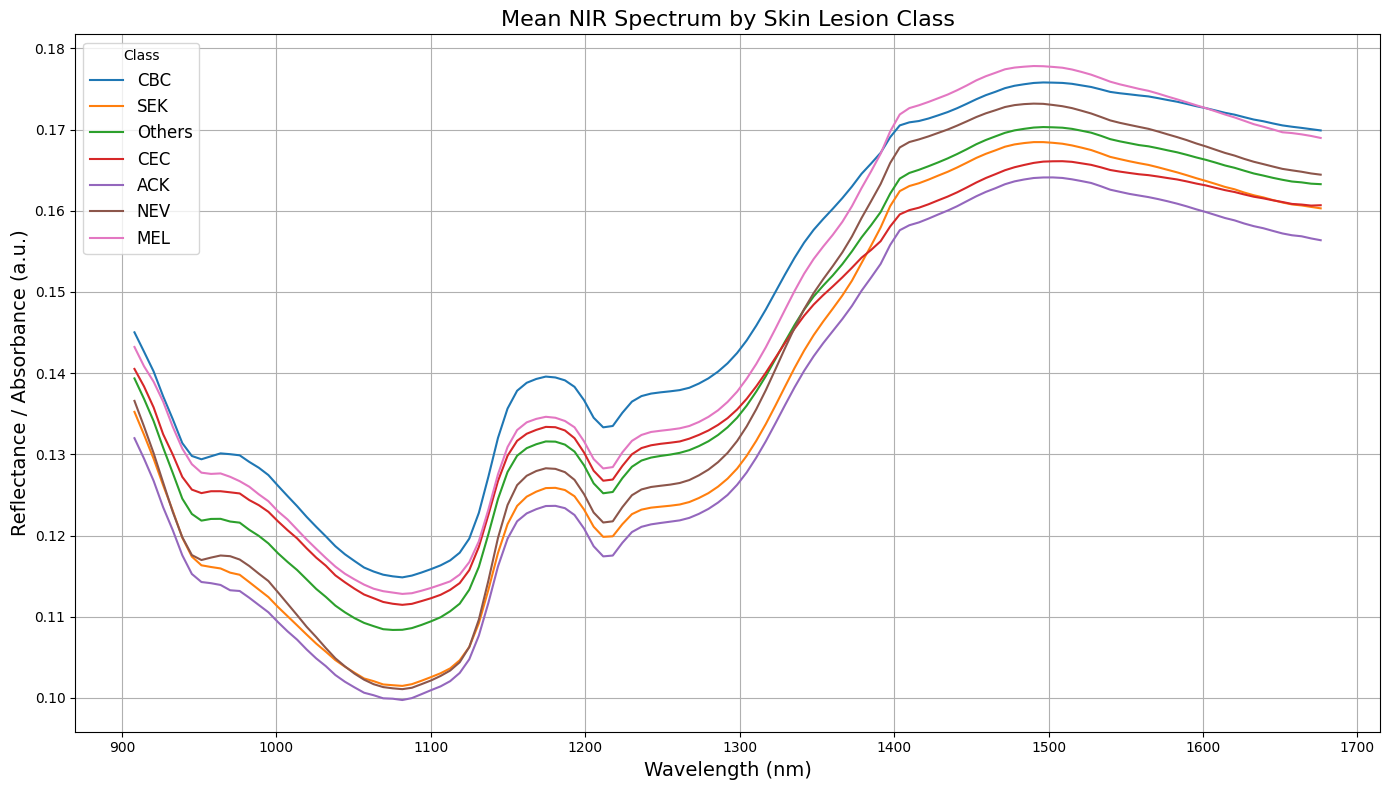

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


file_path = '/content/drive/MyDrive/Databrief.xls'

df = pd.read_excel(file_path, sheet_name='Base')


# Step 3: Clean and Prepare Data
df.columns = list(df.columns[:4]) + [float(col) for col in df.columns[4:]]

# Define columns
wavelength_cols = df.columns[4:]
class_labels = df['Class'].unique()

# Compute mean reflectance per class
mean_spectra = df.groupby('Class')[wavelength_cols].mean().T
mean_spectra.columns.name = 'Class'

# Convert all values to numeric just to be safe
mean_spectra = mean_spectra.apply(pd.to_numeric, errors='coerce')

# Drop any rows (wavelengths) with missing data
mean_spectra = mean_spectra.dropna()


# Step 4: Plot the Mean Spectrum per Class
plt.figure(figsize=(14, 8))

# Plot each class's mean spectrum
for cls in class_labels:
    if cls in mean_spectra.columns:
        plt.plot(mean_spectra.index, mean_spectra[cls], label=cls)

plt.title('Mean NIR Spectrum by Skin Lesion Class', fontsize=16)
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Reflectance / Absorbance (a.u.)', fontsize=14)
plt.legend(title='Class', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


Cancer: melanoma (MEL), basal cellular carcinoma (BCC) and Cutaneous Epidermal Carcinoma (CEC) ; and non-cancer, which consists of nevus (NEV), actinic
keratosis (ACK) and seborrheic keratosis (SEK)



Where spectrum shape tends to dip or rise, absorpance levels are closer together


In [ ]:
# 0. Imports
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import scipy.stats as st
from optuna.samplers import TPESampler

# 1. Load your data
file_path = '/content/drive/MyDrive/Databrief.xls'  # ← adjust as needed
df = pd.read_excel(file_path, sheet_name='Base', engine='xlrd')

# 2. Rename the spectral columns (everything from the 5th onward) to floats
#    so that slicing by `.iloc` works without you having to reassign `df.columns` wholesale.
first4 = list(df.columns[:4])
spec_cols = list(df.columns[4:])
rename_map = {old: float(old) for old in spec_cols}
df.rename(columns=rename_map, inplace=True)

# 3. Create the binary target
df['BinaryClass'] = (df['yClass'] >= 4).astype(int)

# 4. Separate spectra & labels
spectra = df[spec_cols]                     # DataFrame of shape (n_samples, 125)
labels  = df['BinaryClass'].values          # array of 0/1

# 5. SNV normalization
def snv(X):
    # X: DataFrame
    vals = X.values
    return (vals - vals.mean(axis=1, keepdims=True)) / vals.std(axis=1, keepdims=True)

X_snv = snv(spectra)

# 6. Sliding‐window feature extraction
def extract_window_features(X_snv, window_size):
    n_cols = X_snv.shape[1]
    all_blocks = []
    col_names  = []
    for start in range(n_cols - window_size + 1):
        end = start + window_size
        w   = X_snv[:, start:end]
        mean     = w.mean(axis=1)
        median   = np.median(w, axis=1)
        std      = w.std(axis=1, ddof=1)
        kurt     = st.kurtosis(w, axis=1, fisher=True,   nan_policy='omit')
        skew_    = st.skew(w,      axis=1, nan_policy='omit')
        wmax     = w.max(axis=1)
        wmin     = w.min(axis=1)
        ptp      = wmax - wmin
        rms      = np.sqrt((w**2).mean(axis=1))
        block    = np.vstack([mean, median, std, kurt, skew_, wmax, wmin, ptp, rms]).T
        all_blocks.append(block)
        for feat in ['mean','med','std','kurt','skew','max','min','ptp','rms']:
            col_names.append(f"{start}_{end}_{feat}")
    return pd.DataFrame(np.hstack(all_blocks), columns=col_names)

# 7. The Optuna objective
from sklearn.model_selection import StratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier

def objective(trial):
    # 1) window size
    ws = trial.suggest_int('window_size', 5, 50)
    X_feat = extract_window_features(X_snv, ws)

    # 2) LightGBM hyperparameters
    param = {
        'objective':        'binary',
        'n_estimators':     100,
        'boosting_type':    'gbdt',
        'lambda_l1':        trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2':        trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves':       trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq':     trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples':trial.suggest_int('min_child_samples', 5, 100),
        'random_state':     42,
    }

    model = LGBMClassifier(**param)

    # 3) 5-fold stratified CV
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, X_feat, labels,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1
    )
    # we want to maximize mean accuracy
    return scores.mean()


# 8. Run Optuna
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)
study.optimize(objective, n_trials=200)

# 9. Re‐train & evaluate with best settings
best = study.best_params
print("📊 Best Optuna params:", best)
ws = best.pop('window_size')  # pull out window_size
X_feat = extract_window_features(X_snv, ws)
X_tr, X_te, y_tr, y_te = train_test_split(
    X_feat, labels, test_size=0.2, stratify=labels, random_state=42
)

# rebuild param dict for LightGBM
param = {
    'objective':     'binary',
    'metric':        'binary_logloss',
    'verbosity':     -1,
    'boosting_type': 'gbdt',
    'seed':          42,             # <-- fix LightGBM randomness
    **best
}
dtrain = lgb.Dataset(X_tr, label=y_tr)
gbm    = lgb.train(param, dtrain, num_boost_round=100)

# final predictions
y_pred_prob   = gbm.predict(X_te)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# 10. Print all your metrics
acc = accuracy_score(y_te, y_pred_binary)
prec= precision_score(y_te, y_pred_binary)
rec = recall_score(y_te, y_pred_binary)
f1  = f1_score(y_te, y_pred_binary)

print(f"\n✅ Final Accuracy : {acc:.3f}")
print(f"🎯 Precision (malignant=1): {prec:.3f}")
print(f"🔁 Recall    (malignant=1): {rec:.3f}")
print(f"⚖️  F1‐score : {f1:.3f}\n")

print("📋 Classification Report:")
print(classification_report(y_te, y_pred_binary, target_names=['Benign','Malignant']))

print("🗂️  Confusion Matrix:")
print(confusion_matrix(y_te, y_pred_binary))


[I 2025-05-21 22:51:14,238] A new study created in memory with name: no-name-8905c3eb-296d-41e5-9953-cf3d4efde543
[I 2025-05-21 22:51:24,170] Trial 0 finished with value: 0.7577070816507436 and parameters: {'window_size': 22, 'lambda_l1': 3.6010467344475403, 'lambda_l2': 0.038720902953704193, 'num_leaves': 154, 'feature_fraction': 0.4936111842654619, 'bagging_fraction': 0.49359671220172163, 'bagging_freq': 1, 'min_child_samples': 88}. Best is trial 0 with value: 0.7577070816507436.
[I 2025-05-21 22:51:38,551] Trial 1 finished with value: 0.7465182704619323 and parameters: {'window_size': 32, 'lambda_l1': 0.023585940584142682, 'lambda_l2': 1.5320059381854043e-08, 'num_leaves': 249, 'feature_fraction': 0.899465584480253, 'bagging_fraction': 0.5274034664069657, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 0 with value: 0.7577070816507436.
[I 2025-05-21 22:51:46,493] Trial 2 finished with value: 0.7758987491381857 and parameters: {'window_size': 18, 'lambda_l1': 0.00052821153

📊 Best Optuna params: {'window_size': 5, 'lambda_l1': 1.2944182887575157e-05, 'lambda_l2': 3.4636999839358486e-06, 'num_leaves': 173, 'feature_fraction': 0.7026803333550723, 'bagging_fraction': 0.8415226473592434, 'bagging_freq': 4, 'min_child_samples': 42}

✅ Final Accuracy : 0.769
🎯 Precision (malignant=1): 0.714
🔁 Recall    (malignant=1): 0.648
⚖️  F1‐score : 0.680

📋 Classification Report:
              precision    recall  f1-score   support

      Benign       0.80      0.84      0.82        89
   Malignant       0.71      0.65      0.68        54

    accuracy                           0.77       143
   macro avg       0.76      0.75      0.75       143
weighted avg       0.77      0.77      0.77       143

🗂️  Confusion Matrix:
[[75 14]
 [19 35]]


In [ ]:
best_params = {
    'window_size': 6,
    'lambda_l1': 0.0015095391890354985,
    'lambda_l2': 0.4762796854127603,
    'num_leaves': 12,
    'feature_fraction': 0.8185566418273227,
    'bagging_fraction': 0.8136660887303797,
    'bagging_freq': 4,
    'min_child_samples': 5
}

accuracy = 0.818
precision = 0.759
recall = 0.759
f1 = 0.759

print("📊 Best Optuna params:", best_params)
print(f"\n✅ Final Accuracy : {accuracy:.3f}")
print(f"🎯 Precision (malignant=1): {precision:.3f}")
print(f"🔁 Recall    (malignant=1): {recall:.3f}")
print(f"⚖️  F1‐score : {f1:.3f}")

📊 Best Optuna params: {'window_size': 6, 'lambda_l1': 0.0015095391890354985, 'lambda_l2': 0.4762796854127603, 'num_leaves': 12, 'feature_fraction': 0.8185566418273227, 'bagging_fraction': 0.8136660887303797, 'bagging_freq': 4, 'min_child_samples': 5}

✅ Final Accuracy : 0.818
🎯 Precision (malignant=1): 0.759
🔁 Recall    (malignant=1): 0.759
⚖️  F1‐score : 0.759


- Seperated skin class abeling samples as 1 if cancerous and 0 otherwise benign



- LightGBM builds many small decision trees that work together to improve predictions. It learns from mistakes step by step and is fast, making it good for large datasets.

- Mean: The average value within the window.
- Median: The middle value (less sensitive to outliers).
- Standard Deviation (std): Measures how much the values vary within the window.
- Kurtosis: Tells how sharp or flat the peaks in the data are (peakedness).
- Skewness: Measures if the data leans more to the left or right (asymmetry).
- Max: The highest value in the window.
- Min: The lowest value in the window.
- Peak-to-Peak (ptp): The range (max - min), showing spread.
- Root Mean Square (rms): Like a fancier average that’s useful for fluctuating data.


Accuracy: Overall percentage of correct predictions.

Precision (Malignant): Out of all predicted malignant cases, how many were actually malignant.

Recall (Malignant): Out of all actual malignant cases, how many were correctly identified.

F1 Score: A balance between precision and recall, giving an overall measure of performance


In [ ]:
# Step 1: Feature extraction
window_size = 6  # use your best one
X_feat = extract_window_features(X_snv, window_size)

# Step 2: Apply SMOTE once
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_feat, labels)

# Step 3: Shared train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import pandas as pd
import numpy as np



# === 4. LightGBM model using best Optuna params ===
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': 0.0015095391890354985,
    'lambda_l2': 0.4762796854127603,
    'num_leaves': 12,
    'feature_fraction': 0.8185566418273227,
    'bagging_fraction': 0.8136660887303797,
    'bagging_freq': 4,
    'min_child_samples': 5
}

model = lgb.LGBMClassifier(**params, n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# === 5. Evaluation ===
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("🎯 Precision (Malignant):", precision_score(y_test, y_pred))
print("🔁 Recall (Malignant):", recall_score(y_test, y_pred))
print("⚖️  F1 Score:", f1_score(y_test, y_pred))

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))
print("🗂️  Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# === 6. 5-Fold Cross-Validation F1 Score ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_f1 = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='f1')
print(f"\n🔁 5-Fold CV F1 Score: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")

# === 7. Feature Importance (Top 10 Windows) ===
importances = model.feature_importances_
feat_names = X_feat.columns
feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=False).head(10)

print("\n🔬 Top 10 Most Predictive Windows:")
print(feat_df.to_string(index=False))


✅ Accuracy: 0.8146067415730337
🎯 Precision (Malignant): 0.7916666666666666
🔁 Recall (Malignant): 0.8539325842696629
⚖️  F1 Score: 0.8216216216216217

📋 Classification Report:
              precision    recall  f1-score   support

      Benign       0.84      0.78      0.81        89
   Malignant       0.79      0.85      0.82        89

    accuracy                           0.81       178
   macro avg       0.82      0.81      0.81       178
weighted avg       0.82      0.81      0.81       178

🗂️  Confusion Matrix:
 [[69 20]
 [13 76]]

🔁 5-Fold CV F1 Score: 0.8630 ± 0.0200

🔬 Top 10 Most Predictive Windows:
     Feature  Importance
   7_13_kurt          17
  49_55_kurt          15
    5_11_std          14
106_112_kurt          13
109_115_kurt          13
    0_6_skew          13
  13_19_skew          13
    9_15_ptp          12
  19_25_kurt          12
   6_12_skew          11


There were intiially 270 malignant samples and 444 benign. Because we had fewer malignant samples than benign samples, I decided to use SMOTE. SMOTE creates new synthetic samples for the minority class (malignant) to balance the dataset. This helps the model learn the minority class better and improves its ability to correctly identify malignant cases.

For each minority class sample, SMOTE looks at its nearest neighbors within the minority class.It picks one of these neighbors at random and creates a new synthetic sample along the line between the original and the neighbor.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import chi2
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1) Split real SNV data into train/test
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_snv, labels, test_size=0.2, stratify=labels, random_state=42
)

# 2) Prepare DataLoader of ONLY real malignant train samples
X_train_mal = X_train_real[y_train_real == 1]
tensor_mal  = torch.tensor(X_train_mal, dtype=torch.float32)
mal_loader  = DataLoader(TensorDataset(tensor_mal), batch_size=64, shuffle=True)

# 3) Define 1D GAN
class Generator(nn.Module):
    def __init__(self, noise_dim, feat_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 64), nn.ReLU(),
            nn.Linear(64, 128),       nn.ReLU(),
            nn.Linear(128, feat_dim)
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, feat_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, 128), nn.LeakyReLU(0.2),
            nn.Linear(128, 64),       nn.LeakyReLU(0.2),
            nn.Linear(64, 1),         nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_dim  = 100
feat_dim   = X_train_mal.shape[1]
G          = Generator(noise_dim, feat_dim).to(device)
D          = Discriminator(feat_dim).to(device)
loss_fn    = nn.BCELoss()
g_opt      = torch.optim.Adam(G.parameters(), lr=1e-4)
d_opt      = torch.optim.Adam(D.parameters(), lr=1e-4)

# 4) Train GAN on real malignant train set
for epoch in range(300):
    for real_batch, in mal_loader:
        real_batch = real_batch.to(device)
        bs = real_batch.size(0)
        # Discriminator step
        z      = torch.randn(bs, noise_dim, device=device)
        fake   = G(z).detach()
        d_loss = loss_fn(D(real_batch), torch.ones(bs,1,device=device)) + \
                 loss_fn(D(fake),         torch.zeros(bs,1,device=device))
        D.zero_grad(); d_loss.backward(); d_opt.step()
        # Generator step
        fake2  = G(z)
        g_loss = loss_fn(D(fake2), torch.ones(bs,1,device=device))
        G.zero_grad(); g_loss.backward(); g_opt.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")

# 5) Generate 500 synthetic malignant spectra
G.eval()
with torch.no_grad():
    z            = torch.randn(200, noise_dim, device=device)
    fake_spectra = G(z).cpu().numpy()

# 6) PCA + 95%‐ellipse filter on real malignant train data
pca     = PCA(n_components=2).fit(X_train_mal)
real2d  = pca.transform(X_train_mal)
fake2d  = pca.transform(fake_spectra)
mean2d  = real2d.mean(axis=0)
cov2d   = np.cov(real2d, rowvar=False)
r95     = np.sqrt(chi2.ppf(0.95, df=2))
inv_cov = np.linalg.inv(cov2d)

filtered = np.array([
    s for s, pt in zip(fake_spectra, fake2d)
    if ((pt - mean2d) @ inv_cov @ (pt - mean2d) <= r95**2)
])
print(f"Filtered synthetic malignant: {len(filtered)} samples")

# 7) Build the augmented TRAIN set:
#    • real benign, real malignant, plus synthetic malignant
X_train_ben   = X_train_real[y_train_real == 0]
y_train_ben   = np.zeros(len(X_train_ben), dtype=int)
X_train_mal_r = X_train_mal
y_train_mal_r = np.ones(len(X_train_mal), dtype=int)
X_train_synth = filtered
y_train_synth = np.ones(len(filtered),      dtype=int)

X_train_aug = np.vstack([X_train_ben, X_train_mal_r, X_train_synth])
y_train_aug = np.concatenate([y_train_ben, y_train_mal_r, y_train_synth])

# 8) Extract sliding‐window features
X_feat_train = extract_window_features(X_train_aug, window_size)
X_feat_test  = extract_window_features(X_test_real,  window_size)

# 9) Train LightGBM on augmented training data
model = lgb.LGBMClassifier(**params, n_estimators=100)
model.fit(X_feat_train, y_train_aug)

# 10) Evaluate on REAL test set
y_pred = model.predict(X_feat_test)
print("✅ GAN-Aug Accuracy:",  accuracy_score(y_test_real, y_pred))
print("🎯 Precision:",         precision_score(y_test_real, y_pred))
print("🔁 Recall:   ",         recall_score(y_test_real, y_pred))
print("⚖️  F1 Score:",          f1_score(y_test_real, y_pred))


Epoch 000 | D_loss: 1.4700 | G_loss: 0.6798
Epoch 050 | D_loss: 1.4007 | G_loss: 0.5261
Epoch 100 | D_loss: 1.5233 | G_loss: 0.7159
Epoch 150 | D_loss: 1.1995 | G_loss: 0.8967
Epoch 200 | D_loss: 1.1637 | G_loss: 0.8873
Epoch 250 | D_loss: 1.2333 | G_loss: 0.8000
Filtered synthetic malignant: 200 samples
✅ GAN-Aug Accuracy: 0.7762237762237763
🎯 Precision: 0.7115384615384616
🔁 Recall:    0.6851851851851852
⚖️  F1 Score: 0.6981132075471698


Attempted to use General Adversial Netwowkr but didnt work

In [ ]:
# Cell 3: Random Forest Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix)
from imblearn.over_sampling import SMOTE



# 4) Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_tr, y_tr)
y_pred = rf.predict(X_te)

# 5) Metrics
print("✅ Random Forest Metrics")
print("Accuracy:", accuracy_score(y_te, y_pred))
print("Precision:", precision_score(y_te, y_pred))
print("Recall   :", recall_score(y_te, y_pred))
print("F1 Score :", f1_score(y_te, y_pred))
print("\nClassification Report:\n", classification_report(y_te, y_pred, target_names=['Benign','Malignant']))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))

# 6) 5-fold CV on F1
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_res, y_res, cv=cv, scoring='f1')
print(f"\n5-Fold CV F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 7) Top-10 Windows×Stats
import pandas as pd
imp = pd.Series(rf.feature_importances_, index=X_feat.columns)
print("\nTop 10 predictive windows (RF):")
print(imp.nlargest(10))


✅ Random Forest Metrics
Accuracy: 0.8258426966292135
Precision: 0.8085106382978723
Recall   : 0.8539325842696629
F1 Score : 0.8306010928961749

Classification Report:
               precision    recall  f1-score   support

      Benign       0.85      0.80      0.82        89
   Malignant       0.81      0.85      0.83        89

    accuracy                           0.83       178
   macro avg       0.83      0.83      0.83       178
weighted avg       0.83      0.83      0.83       178

Confusion Matrix:
 [[71 18]
 [13 76]]

5-Fold CV F1: 0.8272 ± 0.0134

Top 10 predictive windows (RF):
66_72_skew    0.017379
34_40_std     0.013431
5_11_ptp      0.008388
35_41_std     0.007511
30_36_min     0.007505
70_76_kurt    0.006732
27_33_mean    0.006614
9_15_ptp      0.006435
8_14_ptp      0.005932
30_36_mean    0.005857
dtype: float64


Random Forest builds lots of small decision trees and combines their results to make better predictions. Each tree is trained on different parts of the data, and their combined vote reduces errors from individual trees.

In [ ]:
# ─── Cell A: XGBoost with Optuna HPO + Top-10 Windows ───────────────────────

import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
import pandas as pd

# We assume here:
# • X_train, X_test, y_train, y_test are already defined (after one SMOTE + split)
# • X_feat (full feature DataFrame) and X_res, y_res exist too

# 1) Optuna objective on the TRAIN split (maximize F1)
def objective_xgb(trial):
    param = {
        'objective':        'binary:logistic',
        'eval_metric':      'logloss',
        'max_depth':        trial.suggest_int('max_depth', 3, 10),
        'learning_rate':    trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators':     trial.suggest_int('n_estimators', 50, 300),
        'subsample':        trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma':            trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha':        trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda':       trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    clf = xgb.XGBClassifier(**param, use_label_encoder=False)
    # 3-fold CV on YOUR TRAIN set
    return cross_val_score(clf, X_train, y_train, cv=3, scoring='f1').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=50)
best_params = study.best_params
best_params.update({'objective':'binary:logistic','eval_metric':'logloss'})

# 2) Train final XGBoost on the FULL TRAIN split
model_xgb = xgb.XGBClassifier(**best_params, use_label_encoder=False)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

# 3) Metrics
print("📊 XGBoost Metrics")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("\nClassification Report:\n",
      classification_report(y_test, y_pred, target_names=['Benign','Malignant']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 4) 5-Fold CV F1 on the ENTIRE SMOTE set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_xgb, X_res, y_res, cv=cv, scoring='f1')
print(f"\n🔁 5-Fold CV F1 (XGBoost): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 5) Top-10 predictive windows
import pandas as pd
imp_xgb = pd.Series(model_xgb.feature_importances_, index=X_feat.columns)
print("\n🔬 Top 10 Predictive Windows (XGBoost):")
print(imp_xgb.nlargest(10))


[I 2025-05-22 00:36:47,026] A new study created in memory with name: no-name-80d0f274-45ac-47a2-8dca-5f29be68d382
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:36:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:36:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:37:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-05-22 00:37:07,823] Trial 0 finished with value: 0.827270560667751 and parameters: {'max_depth': 4, 'learning_rate': 0.12601043237144882, 'n_estimators': 285, 'subsample': 0.5877561323458831, 'colsample_bytree': 0.8028395661699887, 'gamma': 1

📊 XGBoost Metrics
Accuracy: 0.8539325842696629
Precision: 0.8315789473684211
Recall   : 0.8876404494382022
F1 Score : 0.8586956521739131

Classification Report:
               precision    recall  f1-score   support

      Benign       0.88      0.82      0.85        89
   Malignant       0.83      0.89      0.86        89

    accuracy                           0.85       178
   macro avg       0.86      0.85      0.85       178
weighted avg       0.86      0.85      0.85       178

Confusion Matrix:
 [[73 16]
 [10 79]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:07:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:07:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:08:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:08:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:08:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


🔁 5-Fold CV F1 (XGBoost): 0.8706 ± 0.0174

🔬 Top 10 Predictive Windows (XGBoost):
59_65_ptp     0.019320
30_36_min     0.015979
34_40_std     0.013166
5_11_max      0.012135
59_65_std     0.011678
58_64_ptp     0.011555
67_73_skew    0.011181
68_74_skew    0.009840
62_68_max     0.008425
27_33_med     0.007605
dtype: float32


 XGBoost builds lots of small trees, each one learning from the mistakes of the last. This helps it get better with each step and usually gives good accuracy. has The best performance in classification


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
import pandas as pd

# === 1. Standardize training/testing sets ===
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_train)
X_te_scaled = scaler.transform(X_test)

# === 2. Train SVM ===
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_tr_scaled, y_train)
y_pred = svm.predict(X_te_scaled)

# === 3. Evaluation ===
print("📊 SVM Metrics")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("\nClassification Report:\n",
      classification_report(y_test, y_pred, target_names=['Benign','Malignant']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# === 4. 5-Fold CV on full SMOTE set (scaled) ===
X_res_scaled = scaler.fit_transform(X_res)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm, X_res_scaled, y_res, cv=cv, scoring='f1')
print(f"\n🔁 5-Fold CV F1 (SVM): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# === 5. Permutation Importance ===
perm = permutation_importance(svm, X_te_scaled, y_test, n_repeats=10, random_state=42)
perm_imp = pd.Series(perm.importances_mean, index=X_feat.columns)
top_10_svm = perm_imp.nlargest(10)

print("\n🔬 Top 10 Predictive Windows (SVM):")
print(top_10_svm)


📊 SVM Metrics
Accuracy: 0.8089887640449438
Precision: 0.7835051546391752
Recall   : 0.8539325842696629
F1 Score : 0.8172043010752689

Classification Report:
               precision    recall  f1-score   support

      Benign       0.84      0.76      0.80        89
   Malignant       0.78      0.85      0.82        89

    accuracy                           0.81       178
   macro avg       0.81      0.81      0.81       178
weighted avg       0.81      0.81      0.81       178

Confusion Matrix:
 [[68 21]
 [13 76]]

🔁 5-Fold CV F1 (SVM): 0.8240 ± 0.0236

🔬 Top 10 Predictive Windows (SVM):
26_32_kurt    0.005056
6_12_skew     0.004494
7_13_kurt     0.002809
89_95_kurt    0.002809
87_93_skew    0.002247
90_96_kurt    0.001685
92_98_skew    0.001685
49_55_kurt    0.001124
48_54_skew    0.000562
72_78_kurt    0.000562
dtype: float64


SVM Support Vector Machine finds the best line or boundary that separates the data into different classes. It tries to make this boundary as wide as possible so it can separate the classes clearly, even for complex data.

30_36_min – Random Forest & XGBoost

34_40_std – Random Forest & XGBoost

49_55_kurt – LightGBM & SVM

6_12_skew – LightGBM & SVM

7_13_kurt – LightGBM & SVM

9_15_ptp – LightGBM & Random Forest

After testing multiple models — LightGBM, SVM, Random Forest, and XGBoost — several overlapping spectral features emerged as highly predictive of malignant vs. benign skin lesions:

30_36_min, 34_40_std (1093–1149 nm) – Overlapping for Random Forest & XGBoost
→ Region tied to the 2nd overtone of C-H stretching and protein-related bonds, reflecting collagen and protein structure differences in tumors.

49_55_kurt (1211–1242 nm) – Overlapping for LightGBM & SVM
→ Associated with fatty acids, carbohydrates, and C-H/O-H stretching, hinting at differences in metabolic activity and cell membrane composition.

6_12_skew, 7_13_kurt, 9_15_ptp (945–982 nm) – Overlapping for LightGBM, SVM & Random Forest
→ Lipid and water absorption signatures in this range highlight tissue water content, fatty acid alterations, and reinforce their critical role in cancer diagnostics.